In [15]:
from zipfile import ZipFile
import pandas as pd
import librosa
from scipy.fftpack import dct
from sklearn import preprocessing
from scipy.spatial import distance
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
with ZipFile('audio_files.zip', 'r') as zipObj:
   # Extract all the contents of zip file in different directory
   zipObj.extractall('audio_file')

In [16]:
df=pd.read_csv('050362578.csv')

**Dataset Statistics:**

In [17]:
classes=[]
length=0
for k in range(len(df)):
    label=df.iloc[k]["tags"].split(",") 
    length=length+len(label)
    classes=classes+label
classes=np.array(classes)    
(unique, counts) = np.unique(classes, return_counts=True)

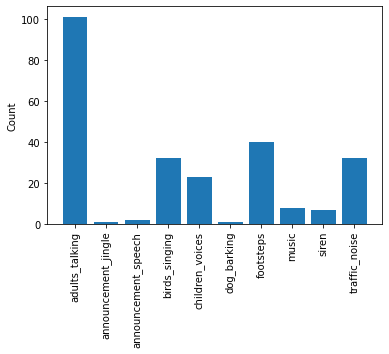

In [18]:
import matplotlib.pyplot as plt
plt.bar(unique,counts)
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.show()

**Mel_Bands Extraction:**

In [19]:
import numpy as np
def extract_melbands(y):
    kwargs_for_mel = {'n_mels': 40}
    mel_band=librosa.feature.melspectrogram(y=y, n_fft=1024, hop_length=512, **kwargs_for_mel)
    mel_band_log = np.log(mel_band+1e-8)
    return mel_band_log

In [20]:
import os 
path='audio_file'
audio_stats=[]
tags=[]
for i in range(len(df)):
    file = df.iloc[i]["fileName"]
    label=df.iloc[i]["tags"]
    tags.append(label)
    file = os.path.splitext(file)[0] 
    filename = path+"/"+str(file)+".wav"
    y, sr = librosa.load(filename,sr=None)
    y=y/np.max(np.abs(y))       #Normalization of data, it is important to normalize them so that they all are of same volume.
    log_mel_spectrum=extract_melbands(y)
    mfcc=dct(log_mel_spectrum)
    mfcc=np.transpose(mfcc)
    mean=np.mean(mfcc,axis=0)
    std=np.std(mfcc,axis=0)
    stats_audio=np.hstack((mean,std))     #An 80X1 vector
    audio_stats.append(stats_audio)
       

**Similarity Matrix Calculation(Cosine Similarity):**

In [21]:
audio_stats=np.array(audio_stats)
sim_mat=np.zeros((131,131))                         #Similarity matrix for 130 files
for i in range(0,len(audio_stats)):
    sample=audio_stats[i]
    for j in range(0,len(audio_stats)):
        sample_next=audio_stats[j]
        Y=1-distance.cosine(sample.reshape(1,-1),sample_next.reshape(1,-1))
        sim_mat[i,j]=Y
        
    

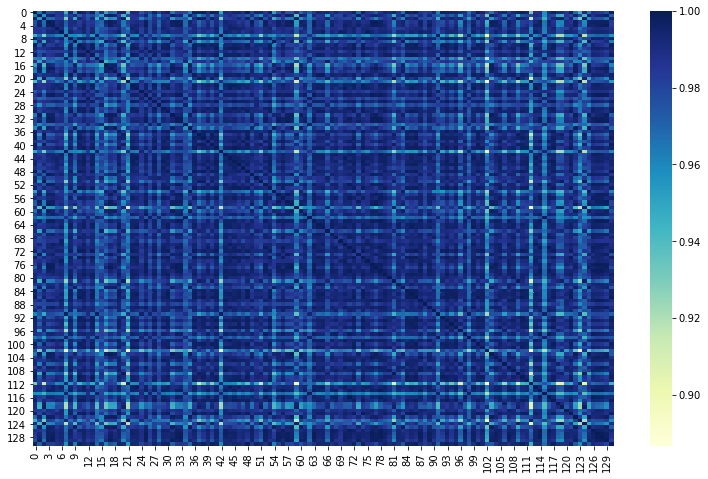

In [39]:
import seaborn as sns
plt.figure(1, figsize=(13,8))
ax = sns.heatmap(sim_mat,cmap="YlGnBu")

Similarity matrix obtained by calculating cosine similarity between 130 files is shown as heat map in Fig 2. As we can see in from Fig 2., the cross-sectional part containing files from 64 to 80(Both x and y axis) and 123 to 129(X axis) is quite dark . Majority of them has airport and park as their acoustic environment. Common classes that occur in these files in major percentage are adults_talking, footsteps and bird_singing. I believe this combination forms a more similarity pattern.

**Average Similarity per class calculations:**

In [1]:
def similar_files_extraction(sim_mat,m,tags,file_names):
    files=[]
    index=[]
    for i in range(0,len(tags)):
        arr_split_1=tags[i].split(",");
        if m in arr_split_1:
            files.append(file_names[i])
            index.append(i)
    return files,index

In [12]:
processed_class=[]
Avg_sim=[]
file_names=np.array(df["fileName"])
for j in tags:
    arr_split=j.split(",");
    for m in arr_split:
        if m not in processed_class:
            processed_class.append(m)
            files,index=similar_files_extraction(sim_mat,m,tags,file_names)
            total=0
            t=0
            for k in range(0,len(index)):
                for h in range((k+1), len(index)):
                    total=total+sim_mat[index[k],index[h]]
                    t=t+1
            if t!=0:
                avg=total/t
            else:
                avg=total
            Avg_sim.append(avg)
            
            

<!DOCTYPE html>
<html>
<head>
<style>
table {
  font-family: arial, sans-serif;
  border-collapse: collapse;
  width: 100%;
}

td, th {
  border: 1px solid #dddddd;
  text-align: left;
  padding: 8px;
}

tr:nth-child(even) {
  background-color: #dddddd;
}
</style>
</head>
<body>

<h2>Average Similarity(In Descending Order)</h2>

<table>
  <tr>
    <th>Class</th>
    <th>Average Similarity</th>
  </tr>
    <tr>
    <td>Announcement Speech</td>
    <td>0.9973</td>
  </tr>
     <tr>
    <td>Birds Singing</td>
    <td>0.9897</td>
  </tr>
    <tr>
    <td>Traffic Noise</td>
    <td>0.9875</td>
  </tr>
  <tr>
    <td>Music</td>
    <td>0.9871</td>
  </tr>
  <tr>
    <td>Footsteps</td>
    <td>0.9857</td>
  </tr>
    <tr>
    <td>Siren</td>
    <td>0.9845</td>
  </tr>
  <tr>
    <td>Adults_Talking</td>
    <td>0.9818</td>
  </tr>
    <tr>
    <td>Children Voices</td>
    <td>0.9753</td>
  </tr>
  <tr>
    <td>Announcement_Jingle(Only 1 file had this)</td>
    <td>0</td>
  </tr>
 <tr>
    <td>Dog Barking(Only 1 file had this)</td>
    <td>0</td>
  </tr>
</table>

</body>
</html>


**Average Similarity of Whole matrix:**

In [13]:
sim_mat.mean()

0.9831263221839153

**Average Class Similarity Analysis:**

If we compare with the avarage value of 0.9831, it can be seen that classes "footsteps","birds_singing","traffic_noise", "siren" and "announcement_speech", "music" have higher value than average similarity. This means that these sounds have a distinct pattern in their mel-spectograms  that can identified and categorized. Also, during annotation process these sounds were commonly occuring together, footsteps, adults_talking/ footsteps, bird_sounds. 

**Similarity meaning in terms of cosine vectors:**

The main intuition beind this is if 2 vectors are perfectly the same, then similarity is 1(angle=0)[Similarity is difined as the cosine of angle between two vectors] and thus the distance is 0(1-1=0). The cosine similarity is particularly used in positive space, when the outcome is neatly bounded in [0,1], which is particularly true for our data. So, in the above case, while calculating the similarity matrix, we used cosine similarity between mel-bands means and standard deviations of two  audio files(Pairs of 130 files), in order to understand how similar are they.

**There are three acoustic scenes for my data file(airport, park and town-square):**

**Extracting files based on acoustic scene:**

In [22]:
files_airport=[]
files_park=[]
files_square=[]
for i in range(len(df)):
    file = df.iloc[i]["fileName"]
    label=df.iloc[i]["tags"]
    if "airport" in file:
        files_airport.append(i)
    if "park" in file:
        files_park.append(i)
    if "square" in file:
        files_square.append(i)
        

In [28]:
sum_airport=0
count=0
for i in range(0,len(files_airport)):
    for j in range(i+1, len(files_airport)):
        sum_airport=sum_airport+sim_mat[i,j]
        count=count+1
        
        
sum_park=0
count1=0
for i in range(0,len(files_park)):
    for j in range(i+1, len(files_park)):
        sum_park=sum_park+sim_mat[i,j]
        count1=count1+1
        

sum_square=0
count2=0
for i in range(0,len(files_square)):
    for j in range(i+1, len(files_square)):
        sum_square=sum_square+sim_mat[i,j]
        count2=count2+1
    

<!DOCTYPE html>
<html>
<head>
<style>
table {
  font-family: arial, sans-serif;
  border-collapse: collapse;
  width: 100%;
}

td, th {
  border: 1px solid #dddddd;
  text-align: left;
  padding: 8px;
}

tr:nth-child(even) {
  background-color: #dddddd;
}
</style>
</head>
<body>

<h2>Average Similarity(In Descending Order)</h2>

<table>
  <tr>
    <th>Acoustic Scene</th>
    <th>Average Similarity</th>
  </tr>
    <tr>
    <td>Airport</td>
    <td>0.9824</td>
  </tr>
     <tr>
    <td>Park</td>
    <td>0.9820</td>
  </tr>
    <tr>
    <td>Square</td>
    <td>0.9808</td>
  </tr>
</table>

</body>
</html>


Airport has the highest acoustic similarity as compared to other scenes.

By observing csv file, it is noticed that the adults talking and footsteps occur more together and have same environment as airport many times.So, the files containing Airport, footsteps+adults_talking has quite a similar pattern.